<a href="https://colab.research.google.com/github/vinodkmani/pandas_exercises/blob/master/VedioMemorability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
import os
drive.mount('/content/drive/',force_remount=True)
os.chdir('/content/drive/My Drive/MachineLearning/CA684_Assignment/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Fetching inception features 
def fetch_inceptionFeatures(filename):
    with open(filename) as f:
        for line in f:
            pairs=line.split()
            incept_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    
    incept = np.zeros(6075)
    for idx in incept_temp.keys():
        incept[idx-1] = incept_temp[idx]            
    return incept

In [0]:
#Fetching captions
def read_captions(fname):
    """Fetching the captions to dataframe"""
    ved = []
    capt = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            ved.append(pairs[0])
            capt.append(pairs[1])
        df['video']=ved
        df['caption']=capt
    return df

In [7]:
!pip install pyprind

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import pyprind
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [0]:
#Fetching inception features
df = pd.DataFrame(columns = ['video', 'arrayInfo'])
dir_inception = '/content/drive/My Drive/MachineLearning/CA684_Assignment/Dev-set/InceptionV3'

for fname in os.listdir(dir_inception):
    if fname.endswith(".txt"):
        path = os.path.join(dir_inception, fname)
        array = fetch_inceptionFeatures(path)
        if "-56" in fname:
          fname.replace('-56','')
          fName= fname.replace(".txt",".webm")
          df = df.append({'video': fName, 'arrayInfo': array}, ignore_index=True)
    else:
        break

In [0]:
df.count()

video        6000
arrayInfo    6000
dtype: int64

In [0]:
count=0
for item in df['video']:
  df['video'][count]=item.replace('-56.webm','.webm')
  count = count + 1

In [0]:
label_path = '/content/drive/My Drive/MachineLearning/CA684_Assignment/Dev-set/Ground-truth/'
labels=pd.read_csv(label_path+'ground-truth.csv')

In [0]:
df_inception = df.merge(labels,on=["video"],how="inner")
df_inception.columns
df_inception.head()

,video,arrayInfo,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video7364.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.891,33,0.900,10
1,video737.webm,"[2.826083e-36, 0.0, 0.0, 0.0, 1.199688e-28, 0....",0.914,44,1.000,11
2,video7373.webm,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.954,31,0.917,12
3,video7370.webm,"[2.318133e-24, 3.561454e-29, 2.048143e-24, 4.1...",0.951,33,0.938,16
4,video7372.webm,"[1.123148e-33, 0.0, 0.0, 0.0, 5.879868e-27, 0....",0.960,47,1.000,15


In [0]:
merged_arr = np.empty((0, 6075))
merged_arr

array([], shape=(0, 6075), dtype=float64)

In [0]:
for line in df_inception['arrayInfo']:
    merged_arr = np.append(merged_arr, np.array([line]), axis = 0)

In [0]:
arrayInfo = df_inception['arrayInfo'].values

In [0]:
X_inception = merged_arr

In [0]:
print(type(X_inception))
X_inception

<class 'numpy.ndarray'>


array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.826083e-36, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [0]:
Y=df_inception[['short-term_memorability','long-term_memorability']].values  #target
X=X_inception #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 6075)
X_test (1200, 6075)
Y_train (4800, 2)
Y_test (1200, 2)


In [0]:
col_num = X_train.shape[1]
col_num

6075

In [0]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(col_num,)))
#The second layer
model.add(Dense(100, activation='relu'))
#The output layer
model.add(Dense(2))

In [0]:
# Compiling and defining early_stopping_monitor 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=2)	

In [0]:
#To calculate Spearmann"s correlation coefficient	
def Calculate_SpearmanScore(Y_prediction,Y_true):
    '''Spearmann"s correlation coefficient'''
    Y_prediction = np.squeeze(Y_prediction)
    Y_true = np.squeeze(Y_true)
    if Y_prediction.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_prediction.shape) == 1:
            Result = pd.DataFrame({'Y_true':Y_true,'Y_prediction':Y_prediction})
            score = Result[['Y_true','Y_prediction']].corr(method='spearman',min_periods=1)
            print('Spearman\'s correlation coefficient : %.3f' % score.iloc[1][0])
        else:
            for ii in range(Y_prediction.shape[1]):
                Calculate_SpearmanScore(Y_prediction[:,ii],Y_true[:,ii])

Train on 3360 samples, validate on 1440 samples
Epoch 1/30
3360/3360 [==============================] - 2s 626us/step - loss: 0.1345 - accuracy: 0.6268 - val_loss: 0.0141 - val_accuracy: 0.6986
Epoch 2/30
3360/3360 [==============================] - 2s 510us/step - loss: 0.0137 - accuracy: 0.7039 - val_loss: 0.0138 - val_accuracy: 0.6965
Epoch 3/30
3360/3360 [==============================] - 2s 517us/step - loss: 0.0136 - accuracy: 0.7051 - val_loss: 0.0141 - val_accuracy: 0.6951
Epoch 4/30
3360/3360 [==============================] - 2s 506us/step - loss: 0.0136 - accuracy: 0.7051 - val_loss: 0.0139 - val_accuracy: 0.6958


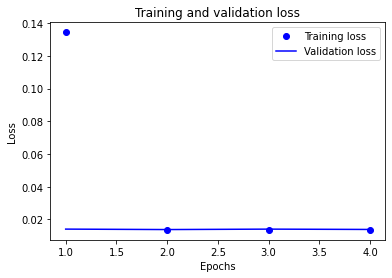

In [0]:
# Fit the model
historyMod=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])
loss = historyMod.history['loss']
val_loss = historyMod.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model_predictions = model.predict(X_test)
print(model_predictions)
Calculate_SpearmanScore(model_predictions, Y_test)

[[0.87100303 0.7734306 ]
 [0.8391351  0.77812517]
 [0.8673724  0.7866619 ]
 ...
 [0.86533433 0.79132134]
 [0.8586352  0.78081083]
 [0.8366358  0.753265  ]]
Spearman's correlation coefficient : 0.131
Spearman's correlation coefficient : 0.041


In [1]:
import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
caption_path='/content/drive/My Drive/MachineLearning/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
captions=read_captions(caption_path)

In [0]:
#Remove stopwords and punctuations
from string import punctuation
for i, cap in enumerate(captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    captions.loc[i,'caption'] = rmv_stopwords #updating the original captions

In [12]:
captions.head()

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot


In [13]:

#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
captions_bag = vectorizer.fit_transform(captions.caption).toarray()
type(captions_bag)

numpy.ndarray

In [0]:
X = captions_bag
y = labels[['short-term_memorability','long-term_memorability']].values

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4800, 3112)
X_test   (1200, 3112)
Y_train  (4800, 2)
Y_test   (1200, 2)


In [23]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100,random_state=45)
captions_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

In [0]:
captions_pred = captions_rf.predict(X_test)

In [27]:
Calculate_SpearmanScore(captions_pred, y_test)

Spearman's correlation coefficient : 0.409
Spearman's correlation coefficient : 0.176


CREATING MODEL WITH CAPTIONS

In [34]:
X = captions_bag
y = labels[['short-term_memorability','long-term_memorability']].values
print(f'X: ({len(X)})')
print(f'y:{y.shape}')

X: (6000)
y:(6000, 2)


In [35]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45)
rf_regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

In [0]:
#Including test Ground_Truth csv file
        label_test_path = '/content/drive/My Drive/MachineLearning/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
        labels_test=pd.read_csv(label_test_path)



In [0]:
captions_test_path ='/content/drive/My Drive/MachineLearning/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
captions_test = read_captions(captions_test_path)

In [40]:
captions_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [0]:

#Removing punctuation and stopwords
for i, cap in enumerate(captions_test['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    captions_test.loc[i,'caption'] = rmv_stopwords #updating the original captions 

In [43]:
captions_test.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


In [44]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
test_captions_bag = vectorizer.fit_transform(captions_test.caption).toarray()
type(test_captions_bag)

print(f'Development Vocabulary Size   : {len(captions_bag[0])}')
print(f'Testing Vocabulary Size       : {len(test_captions_bag[0])}')

Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


In [45]:
test_pred = rf_regressor.predict(test_captions_bag)
pred = pd.DataFrame()
type(test_pred)
pred['short-term'] = test_pred[:,0]
pred['long-term'] = test_pred[:,1]
pred.head()

,short-term,long-term
0,0.854635,0.712699
1,0.898883,0.781500
2,0.841901,0.805625
3,0.915282,0.826990
4,0.866134,0.711727


In [0]:
pred.to_csv('/content/drive/My Drive/MachineLearning/Results.csv',index=False)